In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import selfies as sf
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
from rdkit import Chem
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
import plotly.express as px

In [2]:
df = pd.read_csv("../smiles_selfies_full.csv")

df['tokens'] = df['selfies'].apply(lambda x: list(sf.split_selfies(x)))

all_tokens =  [tok for seq in df['tokens'] for tok in seq]
vocab = sorted(set(all_tokens))
#MAKS = "<MASK>"
PAD = "<PAD>"
SOS = "<SOS>"
EOS = "<EOS>"
vocab = [PAD, SOS, EOS] + vocab
vocab_size = len(vocab)

tok2id = {tok: idx for idx, tok in enumerate(vocab)}
id2tok = {idx: tok for tok, idx in tok2id.items()}

def full_molecule_tokens_to_ids(tokens, tok2id):
    return np.array([1] + [tok2id[t] for t in tokens] + [2])

df['token_ids'] = df['tokens'].apply(lambda toks: full_molecule_tokens_to_ids(toks, tok2id))
df['lenghts'] = df['token_ids'].apply(len)

sequences = df['token_ids'].tolist()
max_len = max(len(seq) for seq in sequences)
padded_data = np.zeros((len(sequences), max_len), dtype=sequences[0].dtype)

for i, seq in enumerate(sequences):
    padded_data[i, :len(seq)] = seq

data = padded_data#[:100_000]
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

print(f"Data shapes: Train {train_data.shape}, Val {val_data.shape}, Test {test_data.shape}")

Data shapes: Train (635522, 77), Val (79440, 77), Test (79441, 77)


In [3]:
@torch.no_grad()
def accuracy(model, loader, pad_id=0, device='cuda'):
    model.eval()
    total_tok = total_correct = total_seq = perfect = 0
    for x in loader:
        x = x.to(device)
        logits, _, _, _ = model(x, mode='eval')
        for i, logit in enumerate(logits):
            pred = logit.argmax(-1)      # [L_pred]
            true = x[i]
            true_len = (true != pad_id).sum().item()
            if true_len == 0:
                continue
            if len(pred) < true_len:
                pad = torch.full(
                    (true_len - len(pred),),
                    pad_id,
                    device=pred.device,
                    dtype=pred.dtype
                )
                pred = torch.cat([pred, pad], dim=0)
            else:
                pred = pred[:true_len]
            true = true[:true_len]
            correct = (pred == true)
            total_correct += correct.sum().item()
            total_tok += true_len
            perfect += int(correct.all())
            total_seq += 1
    return (total_correct / max(total_tok, 1),perfect / max(total_seq, 1))

@torch.no_grad()
def accuracy_train(model, loader, pad_id=0, device='cuda'):
    model.eval()
    for x in loader:
        x = x.to(device)
        logits, _, _, _ = model(x, mode='train')
        preds = torch.argmax(logits, dim=-1)
        mask = (x != pad_id)
        correct_tokens = (preds == x) & mask
        token_acc = correct_tokens.sum().float() / (mask.sum().float() + 1e-8)
        seq_correct = ((preds == x) | ~mask).all(dim=1)
        seq_acc = seq_correct.float().mean()
    return token_acc.cpu().numpy(), seq_acc.cpu().numpy()

### Model

In [5]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_len, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        pe = torch.zeros(max_len, hidden_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2).float() * (-math.log(10000.0) / hidden_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        if x.dim() == 3:
            B, T, _ = x.shape
        elif x.dim() == 2:
            B, T = x.shape
        if T <= self.pe.size(0):
            pe = self.pe[:T]  
        else:
            device = x.device
            H = self.hidden_size
            position = torch.arange(T, dtype=torch.float, device=device).unsqueeze(1)  
            div_term = torch.exp(torch.arange(0, H, 2, device=device).float() * (-math.log(10000.0)/H))
            pe = torch.zeros(T, H, device=device)
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  

class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        self.d = hidden_size // num_heads
        self.num_heads = num_heads
        self.W_q = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_k = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_v = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_o = nn.Linear(hidden_size, hidden_size, bias=False)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.ff = nn.Sequential(
            nn.Linear(hidden_size, 4*hidden_size),
            nn.GELU(),
            nn.Dropout(p=0.1),
            nn.Linear(4*hidden_size, hidden_size),
            nn.Dropout(p=0.1)
        )
        self.norm2 = nn.LayerNorm(hidden_size)

    def forward(self, q, k, v, pad_mask=None, causal=False):   # [B, T, H]
        B, T_q, H = q.shape
        _, T_v, _ = v.shape
        Q = self.W_q(q)     # [B, T, num_heads * H]
        K = self.W_k(k)
        V = self.W_v(v)
        Q = Q.view(B, self.num_heads, T_q, self.d) # [B, A, T, H]
        K = K.view(B, self.num_heads, T_v, self.d)
        V = V.view(B, self.num_heads, T_v, self.d)

        attn_logits = torch.einsum('baih,bajh->baij', Q, K)    # [B, A, T, H] @ [B, A, H, T] = [B, A, T, T]

        if pad_mask is not None:
            key_mask = pad_mask[:, None, None, :]  # [B,1,1,T_k]
            attn_logits = attn_logits.masked_fill(~key_mask, float('-inf'))

        attn = F.softmax(attn_logits / math.sqrt(self.d), dim=-1)

        if pad_mask is not None:
            query_mask = pad_mask[:, None, :, None]  # [B,1,T_q,1]
            attn = attn * query_mask.float()

        h = torch.einsum('baij,bajh->baih',attn, V)  # [B, A, T, H]
        h = h.view(B, T_q, H)  # [B, T, A*H]
        h = self.W_o(h)     # [B, T, H]
        
        h = self.norm1(q + h)
        h = self.norm2(h + self.ff(h))
        return h
    
def phi(x):
    return F.elu(x) + 1

class LinearMultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        assert hidden_size % num_heads == 0
        
        self.num_heads = num_heads
        self.d = hidden_size // num_heads

        self.W_q = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_k = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_v = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_o = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, q, k, v, mask=None):
        B, Tq, H = q.shape
        _, Tk, _ = k.shape

        Q = self.W_q(q)
        K = self.W_k(k)
        V = self.W_v(v)
        Q = Q.view(B, Tq, self.num_heads, self.d).transpose(1, 2)
        K = K.view(B, Tk, self.num_heads, self.d).transpose(1, 2)
        V = V.view(B, Tk, self.num_heads, self.d).transpose(1, 2)
        Q = phi(Q)
        K = phi(K)

        if mask is not None:
            mask = mask[:, None, :, None]  # [B, 1, T, 1]
            #Q = Q * mask
            K = K * mask
            V = V * mask

        K_sum = K.sum(dim=2)                      # [B, heads, d]
        KV = torch.einsum('bhtd,bhtv->bhdv', K, V)  # [B, heads, d, d]
        Z = 1 / (torch.einsum('bhtd,bhd->bht', Q, K_sum) + 1e-6)

        out = torch.einsum('bhtd,bhdv,bht->bhtv', Q, KV, Z)
        out = out.transpose(1, 2).contiguous().view(B, Tq, H)
        out = self.W_o(out)
        return out

class MultiSlotPooling(nn.Module):
    def __init__(self, hidden_size, num_slots):
        super().__init__()
        self.queries = nn.Parameter(torch.randn(num_slots, hidden_size))

    def forward(self, h, mask):
        # h: [B, T, D]
        # mask: [B, T]
        attn = torch.einsum("kd,btd->bkt", self.queries, h)
        attn = attn.masked_fill(~mask[:, None, :], -1e9)
        attn = F.softmax(attn, dim=-1)
        slots = torch.einsum("bkt,btd->bkd", attn, h)
        return slots

class LinearSlotPooling(nn.Module):
    def __init__(self, hidden_size, num_slots):
        super().__init__()
        self.queries = nn.Parameter(torch.randn(num_slots, hidden_size))
        self.norm = nn.LayerNorm(hidden_size)

    def phi(self, x):
        return F.elu(x) + 1.0

    def forward(self, h, mask):
        Q = self.phi(self.queries)                 # [K, H]
        H = self.phi(h)                            # [B, T, H]

        w = torch.einsum("kh,bth->bkt", Q, H)
        w = w * mask[:, None, :]                   # mask padding

        slots = torch.einsum("bkt,bth->bkh", w, h)

        Z = w.sum(dim=-1, keepdim=True) + 1e-6
        slots = slots / Z

        return self.norm(slots)

class VaeTransformer(nn.Module):
    def __init__(self, vocab_size, hidden_size, latent_size, max_len, attn_heads=8, num_slots=8, layers=1, mask_token_id=0, seed_size=5):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_slots = num_slots
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_encoder = PositionalEmbedding(max_len, hidden_size)
        
        # Encoder
        self.encoder_blocks = nn.ModuleList([MultiHeadAttention(hidden_size, attn_heads) for _ in range(layers)])
        #self.pool = MultiSlotPooling(hidden_size, num_slots=num_slots)
        self.pool = LinearSlotPooling(hidden_size, num_slots=num_slots)

        # VAE heads
        self.fc_mu = nn.Linear(num_slots * hidden_size, latent_size)
        self.fc_logvar = nn.Linear(num_slots * hidden_size, latent_size)
        
        # Decoder
        self.max_len = max_len
        self.fc_z2h = nn.Linear(latent_size, num_slots * hidden_size)
        self.fc_lenght = nn.Sequential(
            nn.Linear(latent_size, latent_size), 
            nn.GELU(), 
            nn.Linear(latent_size, latent_size//2),
            nn.GELU(),
            nn.Linear(latent_size // 2, 1)
        )
        #self.cross_block = nn.MultiheadAttention(hidden_size, attn_heads, batch_first=True)
        self.cross_block = LinearMultiHeadAttention(hidden_size, attn_heads)
        self.decoder_blocks = nn.ModuleList([MultiHeadAttention(hidden_size, num_heads=attn_heads) for _ in range(layers)])
        
        # Output head
        self.fc_output = nn.Linear(hidden_size, vocab_size)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def encode(self, x):  
        B, _ = x.shape
        h = self.embedding(x)    # [B, T, H]
        pos_encoding = self.pos_encoder(x)
        h_pos = h + pos_encoding
        mask = (x != 0)
        
        for block in self.encoder_blocks:
            h = block(h_pos, h_pos, h, pad_mask=mask)
        h = h * mask[:, :, None]

        slots = self.pool(h, mask)
        slots = slots - slots.mean(dim=1, keepdim=True)
        slots = F.layer_norm(slots, slots.shape[-1:])
        z_input = slots.reshape(B, -1)
        mu = self.fc_mu(z_input)
        logvar = self.fc_logvar(z_input)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu
   
    def decode(self, z, x=None, mode='eval', sos_id=1):
        B, _ = z.shape
        pred_len = F.softplus(self.fc_lenght(z.detach())).squeeze(-1)
        pred_len_i = torch.round(pred_len).long()
        pred_len_i = torch.clamp(pred_len_i, min=1)
        
        z = self.fc_z2h(z)
        slots = z.view(B, self.num_slots, self.hidden_size)
        slots = slots - slots.mean(dim=1, keepdim=True)
        slots = F.layer_norm(slots, slots.shape[-1:])
        max_len_batch = int(pred_len.max().item())
        t = torch.arange(max_len_batch, device=z.device)[None, :] 

        pos_q = self.pos_encoder(torch.empty(B, max_len_batch, self.hidden_size, device=z.device))
        pos_q = pos_q.expand(B, -1, -1).detach().clone()
        pos_q[:, 0, :] = self.embedding.weight[sos_id]
        
        h = self.cross_block(pos_q, slots, slots)  
        h = F.layer_norm(h, h.shape[-1:]) 

        dec_mask = t < pred_len_i[:, None]

        for block in self.decoder_blocks:
            h = block(h, h, h, pad_mask=dec_mask)
        
        logits = self.fc_output(h)
        
        return logits, pred_len
        
    def forward(self, x, mode='eval'):  
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        if mode == 'train':
            logits, pred_lenght = self.decode(z, x, mode='train')
        else:
            logits, pred_lenght = self.decode(z, mode='eval')
        
        return logits, mu, logvar, pred_lenght        

def vae_loss(logits, x, mu, logvar, pred_len, beta=0.01, alpha=0.1, pad_id=0):
    B, T_pred, V = logits.shape
    T_x = x.size(1)
    true_len = (x != pad_id).sum(dim=-1)                # [B]
    pred_len_i = torch.round(pred_len).long().clamp(min=1)  # [B]

    t_pred = torch.arange(T_pred, device=x.device)[None, :]   # [1, T_pred]
    t_x = torch.arange(T_x, device=x.device)[None, :]         # [1, T_x]

    pred_mask = t_pred < pred_len_i[:, None]           # [B, T_pred]
    true_mask = t_x < true_len[:, None]                # [B, T_x]

    min_T = min(T_pred, T_x)
    pred_mask = pred_mask[:, :min_T]
    true_mask = true_mask[:, :min_T]

    mask = pred_mask & true_mask                        # [B, T]

    logits = logits[:, :min_T, :].reshape(-1, V)
    targets = x[:, :min_T].reshape(-1)
    mask = mask.reshape(-1)

    rec_loss = F.cross_entropy(logits[mask],targets[mask])
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    len_loss = F.mse_loss(pred_len, true_len.float())
    loss = rec_loss + beta * kl_loss + alpha * len_loss
    return loss, rec_loss, kl_loss, len_loss

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

hidden_size = 256
attention_heads = 8
num_slots = 8
layers = 1
latent_size = 512

model = VaeTransformer(vocab_size, hidden_size, latent_size, max_len, attention_heads, num_slots, layers).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

beta = 0.1
alpha = 1
epochs = 50
batch_size = 128
history = []

train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=False)

for epoch in range(1, epochs+1):
    
    model.train()
    total = 0
    total_rec = 0
    total_kl = 0
    total_len = 0
    total_val = 0
    pbar = tqdm(train_loader)

    for x in pbar:
        x = x.to(device)
        logits, mu, logvar, pred_len = model(x, mode='train')
        
        loss, rec, kl, len_loss = vae_loss(logits, x, mu, logvar, pred_len, beta=beta, alpha=alpha)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pbar.set_postfix({
            "rec": f"{rec.item():.3f}",
            "kl": f"{kl.item():.3f}", 
            "len": f"{len_loss.item():.3f}",
            "tot": f"{loss.item():.3f}",
        })
        total += loss.item()
        total_rec += rec.item()
        total_kl += kl.item()
        total_len += len_loss.item()

    with torch.no_grad():
        model.eval()
        for x in val_loader:
            x = x.to(device)
            logits, mu, logvar, pred_lenght = model(x, mode='train')
            val_loss, val_rec, val_kl, val_len = vae_loss(
                logits, x, mu, logvar, pred_lenght, 
                beta=beta, alpha=alpha
            )
            total_val += val_loss.item()

    token_acc, seq_acc = accuracy(model, val_loader)
    total = total / len(train_loader)
    total_rec = total_rec / len(train_loader)
    total_kl = total_kl / len(train_loader)
    total_len = total_len / len(train_loader)
    total_val = total_val / len(val_loader)
    history.append((total, total_rec, total_kl, total_val))
    print(f"Epoch: {epoch:03d} | total={total:.4f} | rec={total_rec:.4f} | kl={total_kl:.4f} | "
          f"len={total_len:.4f} | val={total_val:.4f} | "
          f"token_acc={token_acc*100:.2f}% | seq_acc={seq_acc*100:.2f}%")

100%|██████████| 4966/4966 [02:54<00:00, 28.45it/s, rec=0.194, kl=0.760, len=3.351, tot=3.622]   


Epoch: 001 | total=11.0806 | rec=0.6984 | kl=0.9374 | len=10.2885 | val=1.3101 | token_acc=95.91% | seq_acc=45.29%


100%|██████████| 4966/4966 [02:54<00:00, 28.48it/s, rec=0.045, kl=0.852, len=1.004, tot=1.135]


Epoch: 002 | total=1.2573 | rec=0.0832 | kl=0.8912 | len=1.0849 | val=0.6415 | token_acc=99.02% | seq_acc=80.05%


100%|██████████| 4966/4966 [02:54<00:00, 28.51it/s, rec=0.006, kl=0.786, len=0.022, tot=0.106]


Epoch: 003 | total=0.7791 | rec=0.0437 | kl=0.7545 | len=0.6599 | val=0.6968 | token_acc=99.52% | seq_acc=89.23%


100%|██████████| 4966/4966 [02:54<00:00, 28.53it/s, rec=0.011, kl=0.757, len=0.139, tot=0.226]


Epoch: 004 | total=0.5731 | rec=0.0307 | kl=0.6755 | len=0.4749 | val=0.3424 | token_acc=99.67% | seq_acc=92.04%


100%|██████████| 4966/4966 [02:54<00:00, 28.53it/s, rec=0.022, kl=0.485, len=0.156, tot=0.226]


Epoch: 005 | total=0.4432 | rec=0.0242 | kl=0.6214 | len=0.3569 | val=0.2458 | token_acc=99.79% | seq_acc=94.48%


100%|██████████| 4966/4966 [02:54<00:00, 28.48it/s, rec=0.012, kl=0.555, len=0.262, tot=0.330]


Epoch: 006 | total=0.3587 | rec=0.0200 | kl=0.5825 | len=0.2805 | val=0.2584 | token_acc=99.82% | seq_acc=95.30%


100%|██████████| 4966/4966 [02:54<00:00, 28.50it/s, rec=0.001, kl=0.372, len=0.121, tot=0.159]


Epoch: 007 | total=0.3085 | rec=0.0171 | kl=0.5521 | len=0.2362 | val=0.1663 | token_acc=99.88% | seq_acc=96.94%


100%|██████████| 4966/4966 [02:54<00:00, 28.46it/s, rec=0.089, kl=0.484, len=0.012, tot=0.149]


Epoch: 008 | total=0.2814 | rec=0.0152 | kl=0.5298 | len=0.2132 | val=0.1331 | token_acc=99.88% | seq_acc=96.84%


100%|██████████| 4966/4966 [02:55<00:00, 28.24it/s, rec=0.032, kl=0.425, len=0.020, tot=0.095]


Epoch: 009 | total=0.2493 | rec=0.0137 | kl=0.5097 | len=0.1847 | val=0.1544 | token_acc=99.89% | seq_acc=96.95%


100%|██████████| 4966/4966 [02:53<00:00, 28.62it/s, rec=0.026, kl=0.362, len=0.022, tot=0.084]


Epoch: 010 | total=0.2312 | rec=0.0126 | kl=0.4958 | len=0.1691 | val=0.1331 | token_acc=99.92% | seq_acc=97.76%


100%|██████████| 4966/4966 [02:53<00:00, 28.62it/s, rec=0.064, kl=0.726, len=0.017, tot=0.154]


Epoch: 011 | total=0.2364 | rec=0.0118 | kl=0.4868 | len=0.1759 | val=0.1210 | token_acc=99.91% | seq_acc=97.67%


100%|██████████| 4966/4966 [02:53<00:00, 28.56it/s, rec=0.000, kl=0.642, len=0.100, tot=0.165]


Epoch: 012 | total=0.2083 | rec=0.0110 | kl=0.4731 | len=0.1499 | val=0.1682 | token_acc=99.95% | seq_acc=98.66%


100%|██████████| 4966/4966 [02:53<00:00, 28.60it/s, rec=0.011, kl=0.547, len=0.067, tot=0.133]


Epoch: 013 | total=0.2062 | rec=0.0103 | kl=0.4630 | len=0.1496 | val=0.1089 | token_acc=99.94% | seq_acc=98.30%


100%|██████████| 4966/4966 [02:53<00:00, 28.69it/s, rec=0.000, kl=0.413, len=0.000, tot=0.042]


Epoch: 014 | total=0.2043 | rec=0.0097 | kl=0.4547 | len=0.1491 | val=0.1103 | token_acc=99.96% | seq_acc=98.81%


100%|██████████| 4966/4966 [02:53<00:00, 28.68it/s, rec=0.016, kl=0.336, len=0.003, tot=0.053]


Epoch: 015 | total=0.1976 | rec=0.0093 | kl=0.4471 | len=0.1436 | val=0.1302 | token_acc=99.96% | seq_acc=98.85%


100%|██████████| 4966/4966 [02:52<00:00, 28.73it/s, rec=0.000, kl=0.316, len=0.025, tot=0.057]


Epoch: 016 | total=0.1937 | rec=0.0089 | kl=0.4411 | len=0.1407 | val=0.1696 | token_acc=99.96% | seq_acc=98.99%


100%|██████████| 4966/4966 [02:53<00:00, 28.63it/s, rec=0.077, kl=0.400, len=0.086, tot=0.203]


Epoch: 017 | total=0.1885 | rec=0.0086 | kl=0.4354 | len=0.1364 | val=0.1056 | token_acc=99.95% | seq_acc=98.60%


100%|██████████| 4966/4966 [02:53<00:00, 28.60it/s, rec=0.002, kl=0.281, len=0.019, tot=0.048]


Epoch: 018 | total=0.1869 | rec=0.0083 | kl=0.4310 | len=0.1355 | val=0.1365 | token_acc=99.97% | seq_acc=99.09%


100%|██████████| 4966/4966 [02:53<00:00, 28.57it/s, rec=0.006, kl=0.325, len=0.059, tot=0.098]


Epoch: 019 | total=0.1813 | rec=0.0080 | kl=0.4257 | len=0.1307 | val=0.2025 | token_acc=99.97% | seq_acc=99.25%


100%|██████████| 4966/4966 [02:53<00:00, 28.58it/s, rec=0.000, kl=0.287, len=0.030, tot=0.059]


Epoch: 020 | total=0.1837 | rec=0.0078 | kl=0.4226 | len=0.1337 | val=0.1173 | token_acc=99.97% | seq_acc=99.05%


100%|██████████| 4966/4966 [02:53<00:00, 28.59it/s, rec=0.001, kl=0.364, len=0.086, tot=0.123]


Epoch: 021 | total=0.1782 | rec=0.0075 | kl=0.4182 | len=0.1288 | val=0.1011 | token_acc=99.97% | seq_acc=99.14%


100%|██████████| 4966/4966 [02:53<00:00, 28.57it/s, rec=0.003, kl=0.371, len=0.040, tot=0.080]


Epoch: 022 | total=0.1784 | rec=0.0074 | kl=0.4146 | len=0.1295 | val=0.2263 | token_acc=99.98% | seq_acc=99.38%


100%|██████████| 4966/4966 [02:53<00:00, 28.66it/s, rec=0.001, kl=0.483, len=0.008, tot=0.058]


Epoch: 023 | total=0.1765 | rec=0.0072 | kl=0.4123 | len=0.1281 | val=0.0804 | token_acc=99.96% | seq_acc=98.99%


100%|██████████| 4966/4966 [02:53<00:00, 28.63it/s, rec=0.000, kl=0.305, len=0.053, tot=0.084]


Epoch: 024 | total=0.1738 | rec=0.0071 | kl=0.4085 | len=0.1259 | val=0.0980 | token_acc=99.98% | seq_acc=99.40%


100%|██████████| 4966/4966 [02:53<00:00, 28.62it/s, rec=0.002, kl=0.430, len=0.163, tot=0.208]


Epoch: 025 | total=0.1694 | rec=0.0069 | kl=0.4061 | len=0.1218 | val=0.0865 | token_acc=99.97% | seq_acc=99.01%


100%|██████████| 4966/4966 [02:53<00:00, 28.66it/s, rec=0.041, kl=0.339, len=0.019, tot=0.093]


Epoch: 026 | total=0.1709 | rec=0.0068 | kl=0.4032 | len=0.1238 | val=0.0993 | token_acc=99.98% | seq_acc=99.31%


100%|██████████| 4966/4966 [02:54<00:00, 28.53it/s, rec=0.085, kl=0.352, len=0.082, tot=0.202]


Epoch: 027 | total=0.1700 | rec=0.0067 | kl=0.4015 | len=0.1231 | val=0.1648 | token_acc=99.98% | seq_acc=99.35%


100%|██████████| 4966/4966 [02:53<00:00, 28.65it/s, rec=0.019, kl=0.504, len=0.229, tot=0.298]


Epoch: 028 | total=0.1687 | rec=0.0066 | kl=0.3995 | len=0.1222 | val=0.1080 | token_acc=99.96% | seq_acc=98.84%


100%|██████████| 4966/4966 [02:53<00:00, 28.67it/s, rec=0.006, kl=0.568, len=0.124, tot=0.187]


Epoch: 029 | total=0.1677 | rec=0.0065 | kl=0.3971 | len=0.1215 | val=0.0921 | token_acc=99.96% | seq_acc=98.98%


100%|██████████| 4966/4966 [02:53<00:00, 28.66it/s, rec=0.061, kl=0.282, len=0.048, tot=0.138]


Epoch: 030 | total=0.1663 | rec=0.0064 | kl=0.3951 | len=0.1204 | val=0.1267 | token_acc=99.97% | seq_acc=98.91%


100%|██████████| 4966/4966 [02:53<00:00, 28.68it/s, rec=0.000, kl=0.291, len=0.001, tot=0.030]


Epoch: 031 | total=0.1659 | rec=0.0064 | kl=0.3933 | len=0.1202 | val=0.0832 | token_acc=99.97% | seq_acc=99.09%


100%|██████████| 4966/4966 [02:52<00:00, 28.76it/s, rec=0.000, kl=0.377, len=0.079, tot=0.117]


Epoch: 032 | total=0.1659 | rec=0.0062 | kl=0.3911 | len=0.1205 | val=0.0906 | token_acc=99.98% | seq_acc=99.41%


100%|██████████| 4966/4966 [02:52<00:00, 28.78it/s, rec=0.002, kl=0.373, len=0.103, tot=0.142]


Epoch: 033 | total=0.1647 | rec=0.0061 | kl=0.3892 | len=0.1196 | val=0.0927 | token_acc=99.96% | seq_acc=98.89%


100%|██████████| 4966/4966 [02:52<00:00, 28.78it/s, rec=0.013, kl=0.435, len=0.557, tot=0.614]


Epoch: 034 | total=0.1642 | rec=0.0061 | kl=0.3874 | len=0.1194 | val=0.5478 | token_acc=99.99% | seq_acc=99.59%


100%|██████████| 4966/4966 [02:52<00:00, 28.82it/s, rec=0.001, kl=0.319, len=0.029, tot=0.062]


Epoch: 035 | total=0.1635 | rec=0.0060 | kl=0.3857 | len=0.1189 | val=0.1052 | token_acc=99.98% | seq_acc=99.42%


100%|██████████| 4966/4966 [02:52<00:00, 28.79it/s, rec=0.054, kl=0.445, len=0.006, tot=0.104]


Epoch: 036 | total=0.1631 | rec=0.0060 | kl=0.3842 | len=0.1187 | val=0.0966 | token_acc=99.98% | seq_acc=99.51%


100%|██████████| 4966/4966 [02:53<00:00, 28.66it/s, rec=0.000, kl=0.358, len=0.006, tot=0.042]


Epoch: 037 | total=0.1634 | rec=0.0059 | kl=0.3834 | len=0.1191 | val=0.1236 | token_acc=99.98% | seq_acc=99.50%


100%|██████████| 4966/4966 [02:53<00:00, 28.62it/s, rec=0.000, kl=0.356, len=0.055, tot=0.090]


Epoch: 038 | total=0.1640 | rec=0.0058 | kl=0.3812 | len=0.1201 | val=0.1229 | token_acc=99.98% | seq_acc=99.54%


100%|██████████| 4966/4966 [02:52<00:00, 28.71it/s, rec=0.001, kl=0.226, len=0.002, tot=0.025]


Epoch: 039 | total=0.1610 | rec=0.0058 | kl=0.3797 | len=0.1173 | val=0.1104 | token_acc=99.98% | seq_acc=99.53%


100%|██████████| 4966/4966 [02:53<00:00, 28.67it/s, rec=0.018, kl=0.476, len=0.058, tot=0.124]


Epoch: 040 | total=0.1623 | rec=0.0057 | kl=0.3786 | len=0.1187 | val=0.0799 | token_acc=99.97% | seq_acc=99.25%


100%|██████████| 4966/4966 [02:53<00:00, 28.66it/s, rec=0.000, kl=0.236, len=0.023, tot=0.047]


Epoch: 041 | total=0.1632 | rec=0.0057 | kl=0.3774 | len=0.1198 | val=0.1097 | token_acc=99.99% | seq_acc=99.59%


100%|██████████| 4966/4966 [02:54<00:00, 28.53it/s, rec=0.024, kl=0.408, len=0.092, tot=0.157]


Epoch: 042 | total=0.1623 | rec=0.0056 | kl=0.3763 | len=0.1190 | val=0.0786 | token_acc=99.97% | seq_acc=99.22%


100%|██████████| 4966/4966 [02:53<00:00, 28.67it/s, rec=0.001, kl=0.462, len=0.014, tot=0.061]


Epoch: 043 | total=0.1623 | rec=0.0056 | kl=0.3753 | len=0.1192 | val=0.0866 | token_acc=99.98% | seq_acc=99.44%


100%|██████████| 4966/4966 [02:52<00:00, 28.71it/s, rec=0.000, kl=0.380, len=0.174, tot=0.212]


Epoch: 044 | total=0.1651 | rec=0.0055 | kl=0.3736 | len=0.1222 | val=0.2469 | token_acc=99.99% | seq_acc=99.64%


100%|██████████| 4966/4966 [02:52<00:00, 28.72it/s, rec=0.000, kl=0.313, len=0.037, tot=0.068]


Epoch: 045 | total=0.1635 | rec=0.0055 | kl=0.3726 | len=0.1207 | val=0.1203 | token_acc=99.98% | seq_acc=99.48%


100%|██████████| 4966/4966 [02:52<00:00, 28.71it/s, rec=0.000, kl=0.502, len=0.145, tot=0.195]


Epoch: 046 | total=0.1634 | rec=0.0054 | kl=0.3716 | len=0.1208 | val=0.0805 | token_acc=99.97% | seq_acc=99.23%


100%|██████████| 4966/4966 [02:53<00:00, 28.66it/s, rec=0.001, kl=0.558, len=0.052, tot=0.108]


Epoch: 047 | total=0.1633 | rec=0.0054 | kl=0.3703 | len=0.1208 | val=0.1021 | token_acc=99.96% | seq_acc=98.82%


100%|██████████| 4966/4966 [02:53<00:00, 28.67it/s, rec=0.035, kl=0.346, len=0.031, tot=0.100]


Epoch: 048 | total=0.1646 | rec=0.0054 | kl=0.3692 | len=0.1223 | val=0.1078 | token_acc=99.98% | seq_acc=99.47%


100%|██████████| 4966/4966 [02:54<00:00, 28.52it/s, rec=0.008, kl=0.636, len=0.109, tot=0.181]


Epoch: 049 | total=0.1663 | rec=0.0054 | kl=0.3693 | len=0.1240 | val=0.0895 | token_acc=99.97% | seq_acc=99.22%


100%|██████████| 4966/4966 [02:53<00:00, 28.62it/s, rec=0.001, kl=0.393, len=0.060, tot=0.100]


Epoch: 050 | total=0.1633 | rec=0.0053 | kl=0.3679 | len=0.1212 | val=0.0778 | token_acc=99.98% | seq_acc=99.46%


In [7]:
ckpt = {"epoch": epoch, "model": model.state_dict(), "optimizer": optimizer.state_dict(), "history": history,"vocab_size": len(vocab)}
torch.save(ckpt, "trained_models/final(H256-L512-linpool).pt")
print("saved")

saved


In [8]:
token_acc, seq_acc = accuracy(model, val_loader)
print("token_acc=", token_acc)
print("seq_acc=", seq_acc)

token_acc= 0.9998265685826538
seq_acc= 0.9946374622356495


### Testing Latent Space

In [9]:
def tokens_to_selfie(tokens):
    selfie_tokens = [id2tok[int(t)] for t in tokens]
    return "".join(selfie_tokens)

for _ in range(5):
    i = np.random.randint(0, len(val_data))
    x = test_data[i: i+1]
    x = torch.tensor(x, device=device)
    logits, mu, logvar, pred_lenght = model(x, mode='eval')
    print(logits[0].shape)
    tokens = [logits[0].argmax(dim=-1)]
    print(tokens_to_selfie(x[0]))
    print(tokens_to_selfie(tokens[0]))
    print()

torch.Size([27, 110])
<SOS>[F][C][Branch1][C][F][Branch1][C][F][C][=N][C][=C][C][Branch1][=Branch2][C][=N][NH1][C][=C][Ring1][Branch1][Br][=N][Ring1][N]<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
<SOS>[F][C][Branch1][C][F][Branch1][C][F][C][=N][C][=C][C][Branch1][=Branch2][C][=N][NH1][C][=C][Ring1][Branch1][Br][=N][Ring1][N]

torch.Size([54, 110])
<SOS>[C][N][O][C][Branch2][Ring2][Branch2][C][C][Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][C][O][C][=C][C][=C][Branch1][=N][C][=C][C][=C][C][Branch1][Ring1][C][#N][=C][Ring1][Branch2][C][=C][Ring1][=C][Ring2][Ring1][=Branch2][N][=C][Ring2][Ring1][=N][N]<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
<SOS>[C][N][O][C][Branch2][Ring2][Branch2][C][C][Branc

In [10]:
n_samples = 5000
vis_data = data[:n_samples]
vis_loader = DataLoader(vis_data, shuffle=False)
zs = []
with torch.no_grad():
    for x in tqdm(vis_loader):
        x = x.to(device)
        logits, mu, logvar, _ = model(x)
        zs.append(mu.cpu().numpy())

z = np.concatenate(zs, axis=0)
z.shape

100%|██████████| 5000/5000 [00:08<00:00, 616.23it/s]


(5000, 512)

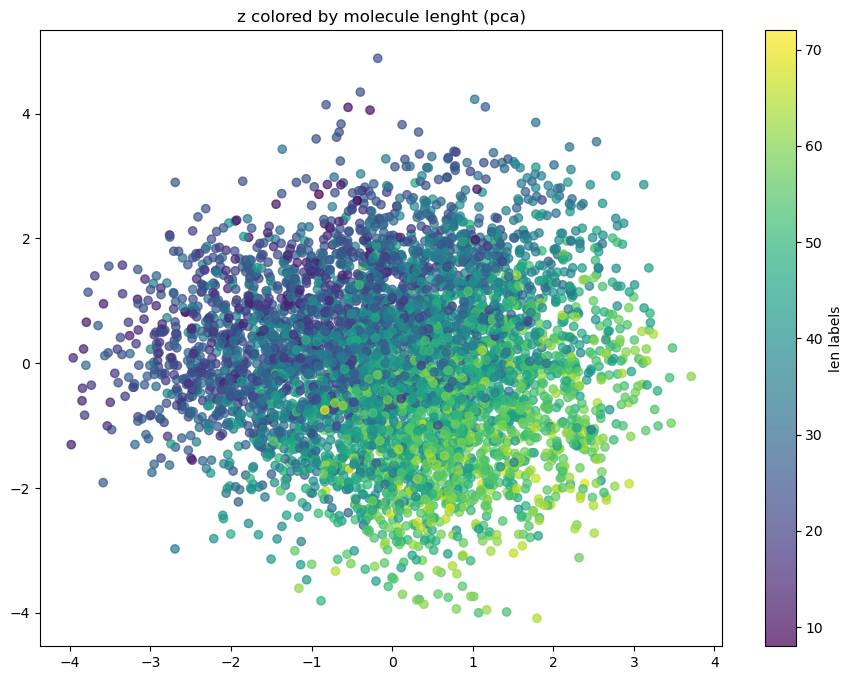

In [12]:
n_samples = 5000
idxs = np.random.choice(z.shape[0], size=n_samples, replace=False)
z_sample = z[idxs]
len_labels = len_labels = np.array(df['lenghts'])[idxs]
z_sample.shape

pca_z = PCA(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=len_labels, cmap='viridis', alpha=0.7)
plt.title(label='z colored by molecule lenght (pca)')
plt.colorbar(label='len labels')
plt.show()

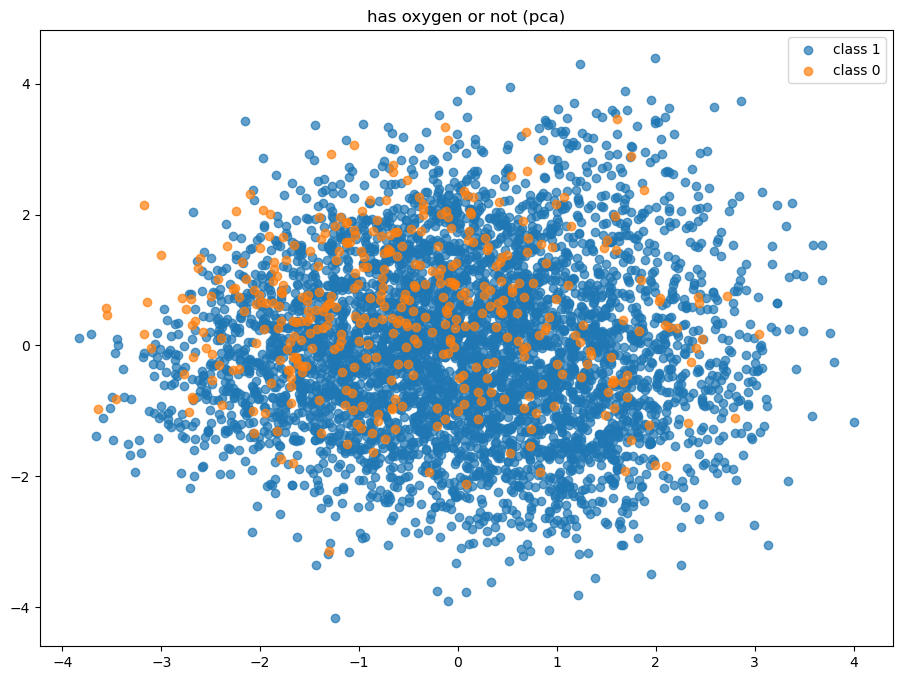

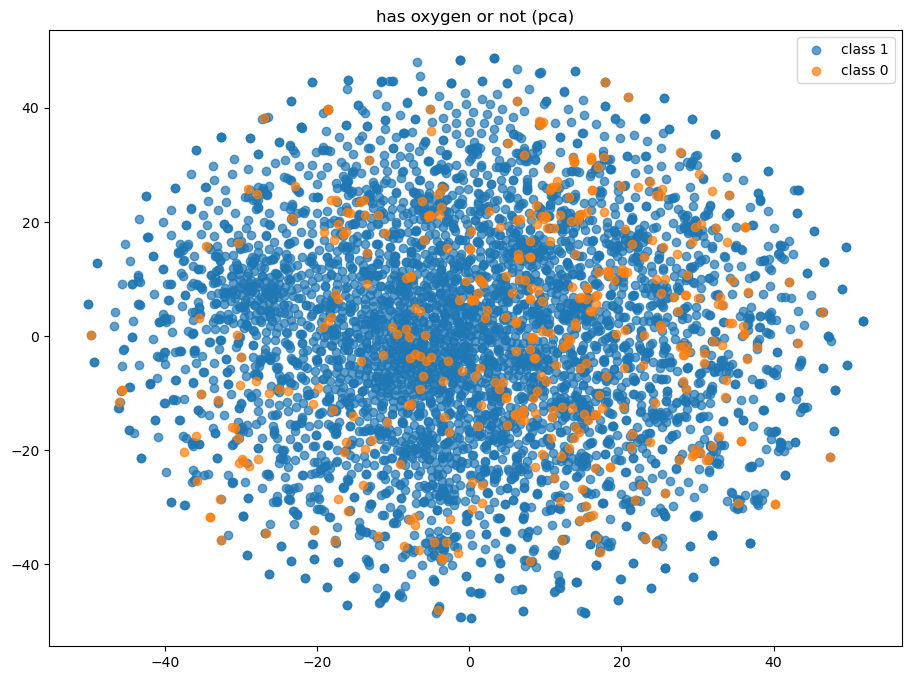

In [14]:
oxygen_labels = df['selfies'].apply(lambda x: 1 if 'O' in x else 0)[idxs]

pca_z = PCA(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
for cls in np.unique(oxygen_labels)[::-1]:
    idx = (oxygen_labels == cls)
    plt.scatter(pca_z[idx, 0], pca_z[idx, 1], label=f"class {cls}", alpha=0.7)
plt.title('has oxygen or not (pca)')
plt.legend()
plt.show()

tsne_z = TSNE().fit_transform(z_sample)
plt.figure(figsize=(11,8))
for cls in np.unique(oxygen_labels)[::-1]:
    idx = (oxygen_labels == cls)
    plt.scatter(tsne_z[idx, 0], tsne_z[idx, 1], label=f"class {cls}", alpha=0.7)
plt.title('has oxygen or not (pca)')
plt.legend()
plt.show()

In [15]:
@torch.no_grad()
def sample_and_validate(model, n_samples, id2tok, sos_id=1, pad_id=0, eos_id=2, device='cuda', latent_scale=1.0):
    model.eval()
    
    B = n_samples
    z = latent_scale * torch.randn(B, latent_size, device=device)
    
    outputs, pred_len = model.decode(z, mode='eval', sos_id=sos_id)
    
    smiles_list = []
    valid_flags = []
    selfies_list = []
    
    for i, logit in enumerate(outputs):
        pred_tokens = torch.argmax(logit, dim=-1).cpu().tolist()
        
        L_pred = len(pred_tokens)
        true_len = max(1, int(torch.round(pred_len[i]).item()))
        if L_pred < true_len:
            pred_tokens += [pad_id] * (true_len - L_pred)
        else:
            pred_tokens = pred_tokens[:true_len]
        
        pred_tokens = [id2tok[t] for t in pred_tokens if t not in [pad_id, sos_id, eos_id]]
        
        selfies_str = ''.join(pred_tokens)
        
        try:
            smiles = sf.decoder(selfies_str)
            mol = Chem.MolFromSmiles(smiles)
            is_valid = mol is not None
        except:
            smiles = None
            is_valid = False
        
        smiles_list.append(smiles)
        valid_flags.append(is_valid)
        selfies_list.append(selfies_str)
    
    valid_ratio = sum(valid_flags) / len(valid_flags)
    return smiles_list, valid_flags, valid_ratio, selfies_list


smiles, valid, ratio, sf_list = sample_and_validate(
    model,
    n_samples=100,
    id2tok=id2tok,
    sos_id=1,
    pad_id=0,
    eos_id=2,
    device=device,
    latent_scale=1  # can scale if you want more exploration
)

print("Validity:", ratio)
for s, v in zip(smiles[:100], valid[:100]):
    print(v, s)

print(sf_list)
print(smiles)

Validity: 1.0
True O
True CC#N
True OCC(=O)C=CCC(C)C1(C)C2N=COC2CC=C1C=C
True C
True C1=C2C1=NCCC=CN(C)CC[C@@H1]2CCC#N
True 
True C
True C
True C1[C@H1]N=CCCCC=C(C)N=CCC1C=NNNC=C=CCC
True N
True CCC=O
True N[C@@H1](C)CC=C(C)CC[C@H1](N)CCCCCC=CCC1OO1
True C1C#C1
True CCCCC[N+1]CCC=O
True CCCC=C=C(C1=C=CF)C(NC1Br)(S=C=C=CCC[N+1]=C(C)CCCF)F
True CC=CCNC=O
True CC(=O)CSC(Br)C=C(C)CC=C=O
True C1=C=NNN1CN
True O
True CNC(C)CCCCCCCCC(C)C(C)CCCCC
True O=C(O)N=C[NH1]C[C@][C@@H1][C@@H1]CF
True CC/C1=C/[C@@H1](F)NC(C([N+1]CC#N)NN=N1)O
True CCCCC=O
True C
True C1CCCC1C=O
True C1C(O)S=C(C=C(C)C)C=C1OC(OCSCC=O)=CC=CCCC=CCC
True N
True CCCCCCI
True O=CCC#CCNCC(=N1)CC1Br
True COC=C1C=C1CC=C=C(C)CBr
True C1CCCCC(NCCl)[NH1]1
True CN=CNCON=CF
True COC=CNNNC(C)=[C@@H1]
True PN[S+1]C=NC(Br)CC=C(F)NNC=C=CCC=C=NC
True O=CN(C)N
True C=1CCCC(C=CC=NC2=C=C2NN(O)C)C=1
True CC[NH1]C=CC(CCC)C
True C1C[N@@]1
True C1C(C)C1(NONCCNOC=CC)C(F)CF
True CC
True C
True O=CCCC=CC1=CC(C)(N)C1CCCCCCCC
True CCPP
True 
True CC=C(

In [16]:
def decode_ids(logits):
    # unwrap lists/tuples
    if isinstance(logits, (list, tuple)):
        logits = logits[-1]  # take final logits

    logits = torch.as_tensor(logits)

    if logits.dim() == 3:      # [B, T, V]
        logits = logits[0]
    if logits.dim() == 2:      # [T, V]
        ids = logits.argmax(dim=-1)
    else:                      # [V]
        ids = logits.argmax().unsqueeze(0)

    return ids.cpu().tolist()

def count_duplicates(lst):
    if not lst:
        return [], []
    unique = [lst[0]]
    counts = [1]
    for x in lst[1:]:
        if x == unique[-1]:
            counts[-1] += 1
        else:
            unique.append(x)
            counts.append(1)
    return unique, counts

def ids_to_smiles(ids, id2tok):
    toks = [id2tok[i] for i in ids]
    toks = [t for t in toks if t not in ("<SOS>", "PAD")]
    if "<EOS>" in toks:
        toks = toks[:toks.index("<EOS>")]

    selfies = "".join(toks)
    try:
        smiles = sf.decoder(selfies)
        return smiles if Chem.MolFromSmiles(smiles) else None
    except:
        return None

def latent_traversal(model, x, dim=0, steps=50, max_delta=5.0):
    model.eval()
    with torch.no_grad():
        mu, _ = model.encode(x.unsqueeze(0).to(device))
    z0 = mu[0]

    xs = torch.linspace(-max_delta, max_delta, steps)
    valids = []

    for s in xs:
        z = z0.clone()
        z[dim] += s
        logits, _ = model.decode(z.unsqueeze(0))
        ids = decode_ids(logits)
        smiles = ids_to_smiles(ids, id2tok)
        valids.append(smiles is not None)
        if smiles:
            print(smiles)

    # plt.plot(xs.cpu(), valids)
    # plt.xlabel("Latent shift")
    # plt.ylabel("Validity")
    # plt.title(f"Latent traversal dim={dim}")
    # plt.show()

def get_logits(decoder_out):
    if isinstance(decoder_out, (tuple, list)):
        decoder_out = decoder_out[0]
        if isinstance(decoder_out, (tuple, list)):
            decoder_out = decoder_out[-1]
    return torch.as_tensor(decoder_out)

def decode_ids_from_logits(logits):
    if logits.dim() == 3:
        logits = logits[0]
    if logits.dim() == 2:
        ids = logits.argmax(dim=-1)
    else:
        ids = logits.argmax().unsqueeze(0)
    return ids.cpu().tolist()

def latent_random_traversal(model, data, steps=300, sigma=0.01):
    model.eval()
    x = torch.tensor(data[np.random.randint(len(data))]).to(device)

    with torch.no_grad():
        mu, _ = model.encode(x.unsqueeze(0))
        z = mu.clone()

    smiles_seq = []

    for _ in range(steps):
        z = z + sigma * torch.randn_like(z)

        dec_out = model.decode(z)
        logits = get_logits(dec_out)
        ids = decode_ids_from_logits(logits)
        smiles = ids_to_smiles(ids, id2tok)

        if smiles is not None:
            smiles_seq.append(smiles)

    unique, counts = count_duplicates(smiles_seq)

    print("Random walk segments:")
    for s, c in zip(unique, counts):
        print(f"{s}  {c}")

def latent_linear_traversal(model, val_data, steps=40):
    model.eval()

    # pick two random molecules
    x1 = torch.tensor(val_data[np.random.randint(len(val_data))]).to(device)
    x2 = torch.tensor(val_data[np.random.randint(len(val_data))]).to(device)

    with torch.no_grad():
        z1, _ = model.encode(x1.unsqueeze(0))
        z2, _ = model.encode(x2.unsqueeze(0))

    alphas = torch.linspace(0, 1, steps)
    smiles_seq = []

    for a in alphas:
        z = (1 - a) * z1 + a * z2
        dec_out = model.decode(z)
        logits = get_logits(dec_out)
        ids = decode_ids_from_logits(logits)
        smiles = ids_to_smiles(ids, id2tok)
        if smiles is not None:
            smiles_seq.append(smiles)

    unique, counts = count_duplicates(smiles_seq)

    print("Linear interpolation:")
    for s, c in zip(unique, counts):
        print(f"{s}  |  {c} steps")

In [17]:
latent_traversal(model, torch.tensor(train_data[np.random.randint(0,len(train_data))]), dim=1, steps=40, max_delta=20)

CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=O)NC1CC2=CC=CC(N)=C2NC1=O
CC(C)(C)OC(=

In [26]:
latent_random_traversal(model, val_data, steps=30, sigma=0.1)

Random walk segments:
N#CC1=CC(F)=CC(N2CCCC=3N=C(C4=CC=C(F)C=N4)OC=3C2)=C1  13
N#CC=CC(F)=CC(NCCC=1CN=C(C=CC=C(F)F)OC=1C)=C  2
N#CC1=CC(F)=CC(N2CCCC=3N=C(C4=CC=C(F)C=N4)OC=3C2)=C1  3
N#CC1=CC(F)=CC(N2CCCC=3N=C(C4=CC=C(F)N=N4)OC=3C2)=C1  3
N#CC=CC(F)=CC(NCCC=1CN=C(C=CC=C(F)F)OC=1C)=C  3
N#CC=CC(F)=CC(NCCCCNN=CNC=CC=C(F)F)=C  1
N#CC1=CC(F)=CC(N2CCCC=3N=C(C4=CC=C(F)N=N4)OC=3C2)=C1  1
N#CC1=CC(F)=CC(N2CCCC=3NN(C4=CC=C(F)ON4)OC=3C2)=C1  1
N#CC=CC(F)=CC(NCC1CCNN=CNC2=CC=C(F)ON2OCC1)=C  1
N#CC=CC(F)=CC(NCCC=1CNN(C=CC=C(F)F)OC=1C)=C  1
N#CC=CC(F)=CC(NCCCCNN(C=CCF)P)=C  1


In [28]:
latent_linear_traversal(model, val_data, steps=40)

Linear interpolation:
CC(=O)O[C@H1]1CC[C@H1]2[C@@H1]3C=CC4=CC(=O)CC[C@]4(C)[C@H1]3CC[C@]12C  |  15 steps
C1C(=O)O[C@H1]CC[C@H1]2[C@@H1]3C=CC4=CC(=O)CC[C@]4(C)[C@H1]3CC[C@]12  |  1 steps
CC(=O)O[C@H1]1CC[C@H1][C@@H1]C2=CC3=CC(=O)CCN3CC4[C@H1]2CC41S  |  1 steps
CC(=O)O[C@H1]CC[C@H1]1[C@@H1]C2=CC3=CC(=O)CCN3CC4C25CC451  |  1 steps
CC(=O)C[C@H1]CC[C@H1][C@@H1]C=C1C2=CC(=O)CCN2CCC3C1C4C3C4SO  |  1 steps
CC(=O)C#CCC=N[C@@H1]C1=C2PNC(=O)CN2CCC3C1C4C3C4SO  |  1 steps
CCCC=O  |  1 steps
CCC=C=O  |  1 steps
C12CC=CCC1C=NCNC(=O)N=C2O  |  1 steps
C1OC=CCC1C=NCNCCN=O  |  1 steps
COC=CCC=NCNCCN=O  |  1 steps
COC=CC(C=NCN1C2CN(CCCC=C[NH1]C3=C=CC(C#N)C2O3)CC1)=N  |  1 steps
COC=CC(OC)=NC(N1C2CN(CCCC=C[NH1]C3=CCC(C#N)C2O3)CC14)=N4  |  2 steps
COC=CC(OC)=NC(NCC1N(CC2CC=C[NH1]C=CC3=C(C#N)C=CSO3)CC1)=N2  |  1 steps
COC=CC(OC)=NC(N1CCN(CCCC2=C[NH1]C3=CC=C(C#N)C=C23)CC1)=N  |  1 steps
COC1=CC(OC)=NC(N2CCN(CCCC3=C[NH1]C4=CC=C(C#N)C=C34)CC2)=N1  |  10 steps


In [29]:
pos_to_probe = 17  # token index we want to predict
latents = []
targets = []

for x in tqdm(val_data):
    x_tensor = torch.tensor(x).unsqueeze(0).to(device)
    with torch.no_grad():
        mu, _ = model.encode(x_tensor)
    z = mu.squeeze(0).cpu().numpy()       # [latent_dim]

    if pos_to_probe < len(x):
        token_id = x[pos_to_probe]
        latents.append(z)
        targets.append(token_id)

latents = np.stack(latents)   # [N, latent_dim]
targets = np.array(targets)   # [N]

X_train, X_test, y_train, y_test = train_test_split(
    latents, targets, test_size=0.2, random_state=42
)

ridge = Ridge(alpha=1.0)  # L2 regularization
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)
y_pred_ids = np.round(y_pred).astype(int)  # round to nearest token ID
y_pred_ids = np.clip(y_pred_ids, 0, len(id2tok)-1)

acc = (y_pred_ids == y_test).mean()
print(f"Prediction accuracy for token at position {pos_to_probe}: {acc:.4f}")

100%|██████████| 79440/79440 [00:50<00:00, 1578.32it/s]


Prediction accuracy for token at position 17: 0.0530


In [30]:
pca = PCA(n_components=3)
pca_z = pca.fit_transform(z_sample)

fig = px.scatter_3d(
    x=pca_z[:,0],
    y=pca_z[:,1],
    z=pca_z[:,2],
    color=len_labels,
    color_continuous_scale='Viridis',
    opacity=0.7,
    title='z colored by molecule length (PCA 3D)'
)

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    width=900,
    height=700
)

fig.show(renderer="browser")   # ← fix: open plot in browser